In [1]:
import sys
sys.path.append(R'C:\Users\pjh7\git\k-wave-python')
import pyfus
from typing import List, Dict, Any, Tuple
import logging
import matplotlib.pyplot as plt
import xarray as xa
root = logging.getLogger()
loglevel = logging.INFO
root.setLevel(loglevel)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(loglevel)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)
import numpy as np


In [2]:

db = pyfus.database.Database(path=R'C:/Users/pjh7/Documents/dom/')
transducer_ids = db.get_transducer_ids()
arr = db.load_transducer(transducer_ids[0])
pt = pyfus.geo.Point(position=(20,0,30), units="mm", radius=2)
focal_pattern = pyfus.bf.RadialPattern(center=True, spoke_radius=5, num_spokes=5)
sim_grid = pyfus.bf.SimulationGrid(dt=2e-7, t_end=100e-6)
pulse = pyfus.bf.Pulse(frequency=400e3, duration=3/400e3)
sequence = pyfus.bf.Sequence()
bfp = pyfus.bf.BeamformingPlan()
plan = pyfus.plan.Plan(pulse=pulse,
                 sequence=sequence,
                 focal_pattern=focal_pattern,
                 sim_grid=sim_grid,
                 bf_plan = bfp)
pts = plan.focal_pattern.get_targets(pt)
coords = plan.sim_grid.get_coords()
params = plan.bf_plan.get_ref_params(coords)
delays, apod = plan.bf_plan.beamform(arr=arr, target=pts[0], params=params)


2023-11-02 09:44:53,410 - pyfus.database - INFO - Transducer IDs: ['vermon', 'vermon2']
2023-11-02 09:44:53,412 - root - INFO - Initializing transducer array


In [6]:
ds, output = pyfus.sim.run_simulation(arr=arr, 
               params=params, 
               delays=delays,
               apod= apod,
               freq = pulse.frequency,
               cycles = np.max([np.round(pulse.duration * pulse.frequency), 20]),
               dt=plan.sim_grid.dt,
               t_end=plan.sim_grid.t_end,
               amplitude = 1,
               db = db,
               save_gridweights=False)

2023-11-02 09:46:45,540 - root - INFO - Calculating grid weights


2023-11-02 09:46:51,943 - root - INFO - Getting binary mask
2023-11-02 09:46:52,779 - root - INFO - Getting distributed source signal
2023-11-02 09:46:53,611 - root - INFO - approximate size of source matrix: 22.56 G B ( float64 precision)
2023-11-02 09:46:53,909 - root - INFO - total computation time : 1.13 s
2023-11-02 09:46:53,910 - root - INFO - Running simulation
2023-11-02 09:46:53,911 - root - INFO - Starting Simulation Setup
2023-11-02 09:46:53,911 - root - INFO -   start time: 02-Nov-2023-09-46-53
2023-11-02 09:46:53,912 - root - INFO - Running k-Wave simulation...
2023-11-02 09:46:53,912 - root - INFO -   start time: 02-Nov-2023-09-46-53
2023-11-02 09:46:53,913 - root - INFO -   reference sound speed: 1500.0 m/s
2023-11-02 09:46:53,913 - root - INFO -   reference sound speed: 1500.0 m/s
2023-11-02 09:46:53,921 - root - INFO -   dt: 200ns, t_end: 99.8us, time steps: 500
2023-11-02 09:46:53,922 - root - INFO -   input grid size: 61 by 61 by 65 grid points (61.0 by 61.0 by 65.0 

In [14]:
print(np.array(output['p']).max(axis=0))
print(np.array(output['p']).min(axis=0))
print(((output['p_max']+output['p_min'])/(output['p_max'].max())).max())
refmat = params.attrs['ref_material']
sz = list(params.coords.sizes.values())
ippa = (np.max(np.array(output['p'])**2, axis=0)/(2*refmat.sound_speed*refmat.density)).reshape(sz)
p_len = np.max([np.round(pulse.duration * pulse.frequency), 20])/pulse.frequency
#ippa = ippa  / (p_len / (output['Nt'] * output['dt']))
ippa_wcm2 = xa.DataArray(ippa*1e-4, coords=params.coords)
print(ds['p_min'].sel(ax=slice(10,None)).max())
print(ippa_wcm2.sel(ax=slice(10,None)).max())
print((33621**2)/(2*refmat.sound_speed*refmat.density)*1e-4)
output['Nt']*output['dt']
ppp = output['p_max'].max()
scale = 1e6/ppp
print(ippa_wcm2.max()*(scale**2))
print(ppp)


[1062.1932 1073.082  1052.9266 ... 1668.4307 1591.6044 1461.3376]
[-1047.0564 -1070.8649 -1039.9152 ... -1653.6028 -1505.7198 -1295.1523]
0.062456325
<xarray.DataArray 'p_min' ()>
array(33680.812, dtype=float32)
<xarray.DataArray ()>
array(0.03781324, dtype=float32)
0.0376790547
<xarray.DataArray ()>
array(33.63635673)
33528.758


In [32]:
plan.to_dict()

AttributeError: 'Plan' object has no attribute 'to_dict'

pnp=10682.751953125
prms=7553.8463477885225
i_rms=38.04039643066533
t_pulse=50.0
i_yavg=33.284516701466096
i_pk=38.04039643066533
i_10max=35.460374882324565


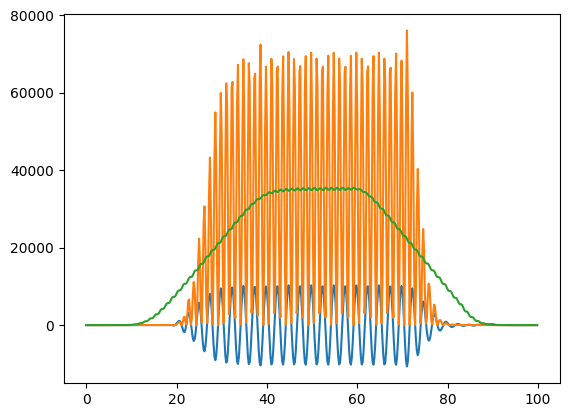

In [30]:
y = output['p'].reshape([-1, 61, 61, 65])[:,20,30,50]
t = output['dt']*np.arange(output['Nt'])*1e6
plt.plot(t,y)
pnp = -1*y.min()
print(f'{pnp=}')
prms = pnp/np.sqrt(2)
print(f'{prms=}')
i_rms = prms**2/(refmat.sound_speed*refmat.density)
print(f'{i_rms=}')
t_pulse = np.max([np.round(pulse.duration * pulse.frequency), 20])/pulse.frequency*1e6
print(f'{t_pulse=}')
i_y = y**2/(refmat.sound_speed*refmat.density)
plt.plot(t,i_y*1e3)
i_yavg = np.sum(i_y)/(len(t)*t_pulse/t[-1])
print(f'{i_yavg=}')
i_pk = pnp**2/(2*refmat.sound_speed*refmat.density)
print(f'{i_pk=}')
k_10 = np.ones(int(10/pulse.frequency/output['dt']))
k_10 = k_10/np.sum(k_10)
i_10 = np.convolve(i_y, k_10, mode='same')
plt.plot(t,i_10*1e3)
i_10max = np.max(i_10)
print(f'{i_10max=}')



In [ ]:
import nibabel as nb
p_max = output['p_min'].data
coords = output.coords
affine = np.eye(3) * np.array([float(np.diff(coords[x][:2])) for x in coords])
origin = np.array([float(coords[x][0]) for x in coords]).reshape(3,1)
affine = np.concatenate([np.concatenate([affine, origin], axis=1),np.array([0,0,0,1]).reshape(1,4)], axis=0)
nb.Nifti1Image(p_max, affine).to_filename("p_max.nii.gz")

In [ ]:
def get_max_cycle_offset(sim_grid, delays):
    zmin = 10
    coords = plan.sim_grid.get_coords(units="mm")
    cvals = [coords['lat'], coords['ele'], coords['ax'].sel(ax=slice(zmin, None))]
    ndg = np.meshgrid(*cvals)
    dists = [np.sqrt((ndg[0]-pos[0])**2 + (ndg[1]-pos[1])**2 + (ndg[2]-pos[2])**2) for pos in arr.get_positions(units="mm")]
    tof = [dist/1500e3 + delays[i] for i, dist in enumerate(dists)]
    dtof = np.array(tof).max(axis=0) - np.array(tof).min(axis=0)
    max_cycle_offset = dtof.max()*pulse.frequency
    return max_cycle_offset


In [ ]:
import vtk
arr_actor = arr.get_actor(units="mm")
renderWindow = vtk.vtkRenderWindow()
renderer = vtk.vtkRenderer()
renderWindow.AddRenderer(renderer)
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
renderer.AddActor(arr_actor)
for pti in pts:
    pt_actor = pti.get_actor()
    renderer.AddActor(pt_actor)
renderWindow.Render()
renderWindowInteractor.Start()

In [ ]:
sys.path.append(R'C:\Users\pjh7\git\k-wave-python')
import kwave
import kwave.data
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.options.simulation_options import SimulationOptions
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.plot import voxel_plot
from kwave.utils.signals import tone_burst
from crc import Crc32, Calculator
import json
import h5py

def get_kgrid(sim_grid: pyfus.bf.SimulationGrid):
    sz =sim_grid.get_size()
    kgrid = kWaveGrid(sz, [sim_grid.get_spacing(units="m")]*3)
    if sim_grid.dt == 0 or sim_grid.t_end == 0:
        kgrid.makeTime(sim_grid.c0)
    else:
        Nt = round(sim_grid.t_end / sim_grid.dt)
        kgrid.setTime(Nt, sim_grid.dt)
    return kgrid

kgrid = get_kgrid(plan.sim_grid)


In [ ]:

def get_karray(arr: pyfus.xdc.Transducer, 
               bli_tolerance: float = 0.5,
               upsampling_rate: int = 5,
               translation: List[float] = [0.,0.,0.],
               rotation: List[float] = [0.,0.,0.]):
    karray = kWaveArray(bli_tolerance=bli_tolerance, upsampling_rate=upsampling_rate)
    for el in arr.elements:
        ele_pos = list(el.get_position(units="m"))
        ele_w, ele_l = el.get_size(units="m")
        ele_angle = list(el.get_angle(units="deg"))
        karray.add_rect_element(ele_pos, ele_w, ele_l, ele_angle)
    translation = kwave.data.Vector(translation)
    rotation = kwave.data.Vector(rotation)
    karray.set_array_position(translation, rotation)
    return karray

karray = get_karray(arr)

In [ ]:

def get_medium(params: xa.Dataset):
    return kWaveMedium(sound_speed=params['sound_speed'].attrs['ref_value'], 
                       density=params['density'].attrs['ref_value'])

medium = get_medium(params)


In [ ]:

def get_sensor(kgrid, record=['p_max','p_min']):
    sensor_mask = np.ones([kgrid.Nx, kgrid.Ny, kgrid.Nz])
    sensor = kSensor(sensor_mask, record=record)
    return sensor

sensor = get_sensor(kgrid)


In [ ]:
kgrid.Nx

In [ ]:

def hash_array_kgrid(kgrid, karray):
    c = Calculator(Crc32.CRC32)
    d = {'x':kgrid.x_vec.tolist(),
        'y':kgrid.y_vec.tolist(),
        'z':kgrid.z_vec.tolist(),
        'transform': karray.array_transformation.tolist(),
        'BLI_tolerance': karray.bli_tolerance,
        'upsampling_rate': karray.upsampling_rate}
    check = c.checksum(bytes(json.dumps(d), 'utf-8'))
    return f'{check:x}'    

h = hash_array_kgrid(kgrid, karray)
available_hashes = db.get_gridweight_hashes(arr.id)
if h in available_hashes:
    grid_weights = db.load_gridweights(arr.id, h)
else:
    logging.info("Calculating grid weights")
    grid_weights = np.array([karray.get_element_grid_weights(kgrid, i) for i in range(karray.number_elements)])
    logging.info("Saving grid weights")
    db.add_gridweights(arr.id, h, grid_weights)

def get_source(kgrid, karray, pulse, delays, apod, source_amp=1, max_cycles=20, grid_weights=None):
    ncycles = np.min([np.ceil(pulse.duration * pulse.frequency), max_cycles])
    source_sig = source_amp * tone_burst(1 / kgrid.dt, pulse.frequency, ncycles, envelope='Rectangular', 
                                         signal_offset=np.round(delays / kgrid.dt).astype(int))
    source = kSource()
    logging.info("Getting binary mask")
    source.p_mask = karray.get_array_binary_mask(kgrid)
    logging.info("Getting distributed source signal")
    source.p = karray.get_distributed_source_signal(kgrid, source_sig, grid_weights=grid_weights)
    return source

source = get_source(kgrid, karray, pulse, delays, apod, grid_weights=grid_weights)

In [ ]:
# SIMULATION
simulation_options = SimulationOptions(
    pml_auto=True,
    pml_inside=False,
    save_to_disk=True,
    data_cast='single'
)
execution_options = SimulationExecutionOptions(is_gpu_simulation=True)

In [ ]:
sensor_data = kspaceFirstOrder3D(kgrid=kgrid, medium=medium, source=source, sensor=sensor,
                                  simulation_options=simulation_options, execution_options=execution_options)
p_max = np.reshape(sensor_data['p_max'], sim_grid.get_size(), order='F')

In [ ]:
import nibabel as nb
nb.Nifti1Image(p_max, np.eye(4)).to_filename("p_max.nii.gz")

In [ ]:
focal_pattern.__dict__